In [1]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
from DS_data_transformation import colors_iterator
from DS_models_stat import cut_cat
from DS_Planck_Unet import val_pix, west_val, east_val
from astropy.coordinates import SkyCoord
from astropy import units as u
from tqdm.notebook import tqdm
%config InlineBackend.figure_format = 'retina'

In [2]:
dirname = '/home/rt2122/Data/original_catalogs/csv/'
true_cats = next(os.walk(dirname))[-1]
true_cats = {os.path.splitext(os.path.basename(s))[0] : os.path.join(dirname, s) for s in true_cats}
true_cats['planck_z'] = '/home/rt2122/Data/clusters/planck_z.csv'
det_cat = '/home/rt2122/Data/detected_cats/full_pz_all_found34_thr0.1_step8_no_fn.csv'

In [3]:
def make_histogram(ax, counts_list, bins, label_list=None, coef_list=None, log=True, add_legend=True):
    if coef_list is None:
        coef_list = [1] * len(counts_list)
    if label_list is None:
        label_list = [''] * len(counts_list)
    
    ci = colors_iterator()
    for i, counts in enumerate(counts_list):
         ax.hist(bins[:-1], bins, weights=counts * coef_list[i], 
                  histtype='step', log=log, label=label_list[i], color=next(ci))
    if add_legend:
        ax.legend(loc='upper left')

In [4]:
def found_all_error_calculated(det_cat, true_cat, small_rads=[0, 400], big_rads=[1000, 1500], saving=None, n_bins=20, func_cat=None,
                              with_tqdm=False):
    
    def func(angle1, angle2, det_cat, true_cat):
        colored = []
        tr = SkyCoord(ra=np.array(true_cat['RA'])*u.degree, dec=np.array(true_cat['DEC'])*u.degree, frame='icrs')
        
        iterator = range(len(det_cat))
        if with_tqdm:
            iterator = tqdm(iterator)

        for i in iterator:
            det = SkyCoord(ra=det_cat.loc[i, 'RA']*u.degree, dec=det_cat.loc[i, 'DEC']*u.degree, frame='icrs')
            sep = tr.separation(det).degree

            count = np.count_nonzero(np.logical_and(angle1/3600 <= sep, sep < angle2/3600))
            colored.extend(count * [det_cat.loc[i, 'max_pred']])

        return colored
    
    def square(rads):
        return np.pi * (rads[1] ** 2 - rads[0] ** 2)
    
    if not (func_cat is None):
        det_cat = func_cat(det_cat)
        true_cat = func_cat(true_cat)
    
    found = func(*small_rads, det_cat, true_cat)
    error = func(*big_rads, det_cat, true_cat)
    
    small_sq = square(small_rads)
    big_sq = square(big_rads)
    
    bins = np.arange(0, 1 + 1/n_bins, 1/n_bins)
    
    found_counts, _ = np.histogram(found, bins)
    error_counts, _ = np.histogram(error, bins)
    all_counts, _ = np.histogram(det_cat['max_pred'], bins)
    
    return bins, found_counts / small_sq, error_counts / big_sq, all_counts, small_sq, big_sq

In [5]:
class Counts_cat:
    def __init__(self, name, found, error, alls, found_coef, err_coef):
        self.name = name
        self.found = found
        self.error = error
        self.alls = alls
        self.found_coef = found_coef
        self.err_coef = err_coef
        
    def error_for_all(self):
        return np.nan_to_num(self.error * self.found_coef/self.alls)
    
    def err_ratio(self):
        return np.nan_to_num(self.error / self.found)
    def precision(self):
        return np.nan_to_num(self.found * self.found_coef / self.alls)
    def corr_precision(self):
        return (1 - self.err_ratio()) * self.precision()

In [6]:
list(true_cats)

['PSZ2', 'MCXC', 'ACT', 'planck_z']

In [15]:
bins = None
counts = []
for cat_name in tqdm(['PSZ2', 'MCXC', 'ACT', 'Abell']):
    bins, *c = found_all_error_calculated(pd.read_csv(det_cat), pd.read_csv(true_cats[cat_name]), n_bins=20) 
                                          #func_cat=lambda x:cut_cat(x, big_pix=west_val+east_val))
    counts.append(Counts_cat(cat_name, *c))

<ipython-input-9-18e0e4164b3a>:14: RuntimeWarning: invalid value encountered in true_divide
  return np.nan_to_num(self.error / self.found)
<ipython-input-9-18e0e4164b3a>:16: RuntimeWarning: invalid value encountered in true_divide
  return np.nan_to_num(self.found * self.found_coef / self.alls)
<ipython-input-9-18e0e4164b3a>:14: RuntimeWarning: invalid value encountered in true_divide
  return np.nan_to_num(self.error / self.found)
<ipython-input-9-18e0e4164b3a>:16: RuntimeWarning: invalid value encountered in true_divide
  return np.nan_to_num(self.found * self.found_coef / self.alls)
<ipython-input-9-18e0e4164b3a>:14: RuntimeWarning: invalid value encountered in true_divide
  return np.nan_to_num(self.error / self.found)
<ipython-input-9-18e0e4164b3a>:16: RuntimeWarning: invalid value encountered in true_divide
  return np.nan_to_num(self.found * self.found_coef / self.alls)
<ipython-input-9-18e0e4164b3a>:14: RuntimeWarning: invalid value encountered in true_divide
  return np.nan_t

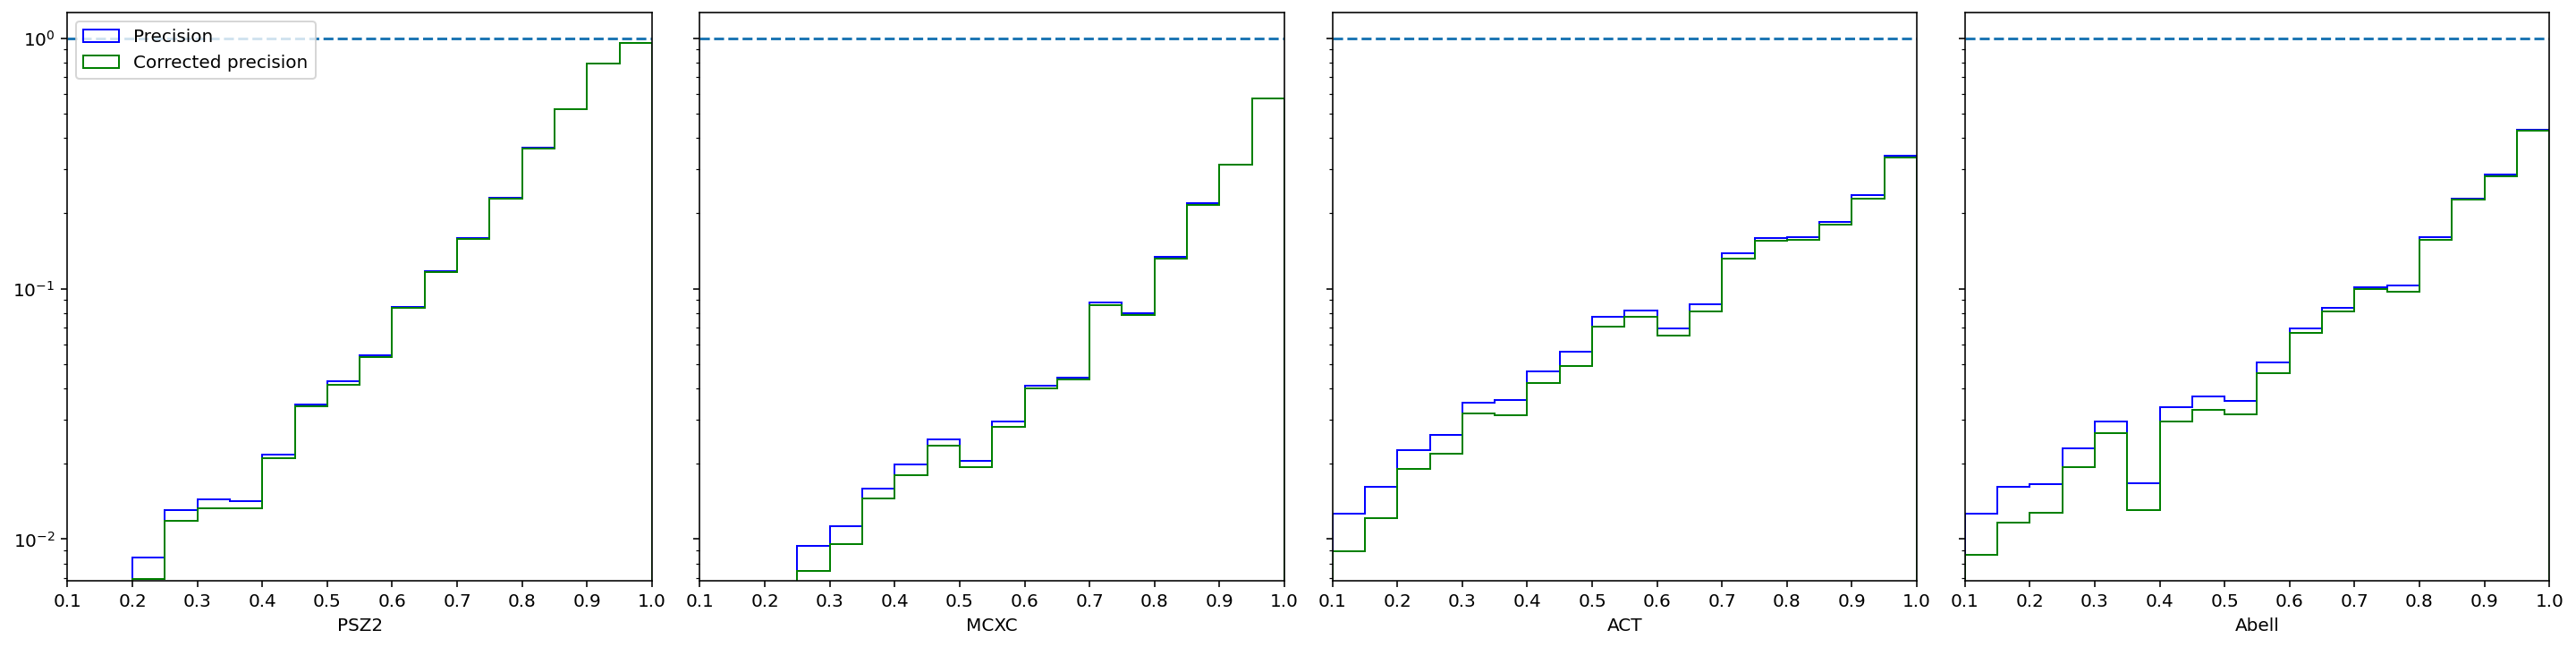

In [31]:
selected =  ['PSZ2', 'MCXC', 'ACT', 'Abell']
fig, ax = plt.subplots(1, len(selected), figsize=(5 * len(selected), 5), sharey=True)
fig.tight_layout()
for i, cat_name in enumerate(selected):
    ax[i].set_xlim([0.1, 1])
    ax[i].axhline(1, linestyle='--')
    ax[i].set_xlabel(cat_name)
    make_histogram(ax[i], [counts[i].err_ratio() * 0, counts[i].precision(), counts[i].corr_precision()], bins, 
                   label_list=['', 'Precision', 'Corrected precision'], log=True, add_legend=i==0)

In [19]:
bins = None
counts_val = []
for cat_name in tqdm(['PSZ2', 'MCXC', 'ACT', 'Abell']):
    bins, *c = found_all_error_calculated(pd.read_csv(det_cat), pd.read_csv(true_cats[cat_name]), n_bins=20, 
                                          func_cat=lambda x:cut_cat(x, big_pix=west_val+east_val))
    counts_val.append(Counts_cat(cat_name, *c))

<ipython-input-9-18e0e4164b3a>:14: RuntimeWarning: invalid value encountered in true_divide
  return np.nan_to_num(self.error / self.found)
<ipython-input-9-18e0e4164b3a>:16: RuntimeWarning: invalid value encountered in true_divide
  return np.nan_to_num(self.found * self.found_coef / self.alls)
<ipython-input-9-18e0e4164b3a>:14: RuntimeWarning: divide by zero encountered in true_divide
  return np.nan_to_num(self.error / self.found)
<ipython-input-9-18e0e4164b3a>:14: RuntimeWarning: invalid value encountered in true_divide
  return np.nan_to_num(self.error / self.found)
<ipython-input-9-18e0e4164b3a>:16: RuntimeWarning: invalid value encountered in true_divide
  return np.nan_to_num(self.found * self.found_coef / self.alls)
/home/rt2122/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_base.py:2450: RuntimeWarning: overflow encountered in double_scalars
  x0, x1 = inverse_trans.transform([x0t - delta, x1t + delta])
<ipython-input-9-18e0e4164b3a>:14: RuntimeWarning: invalid value 

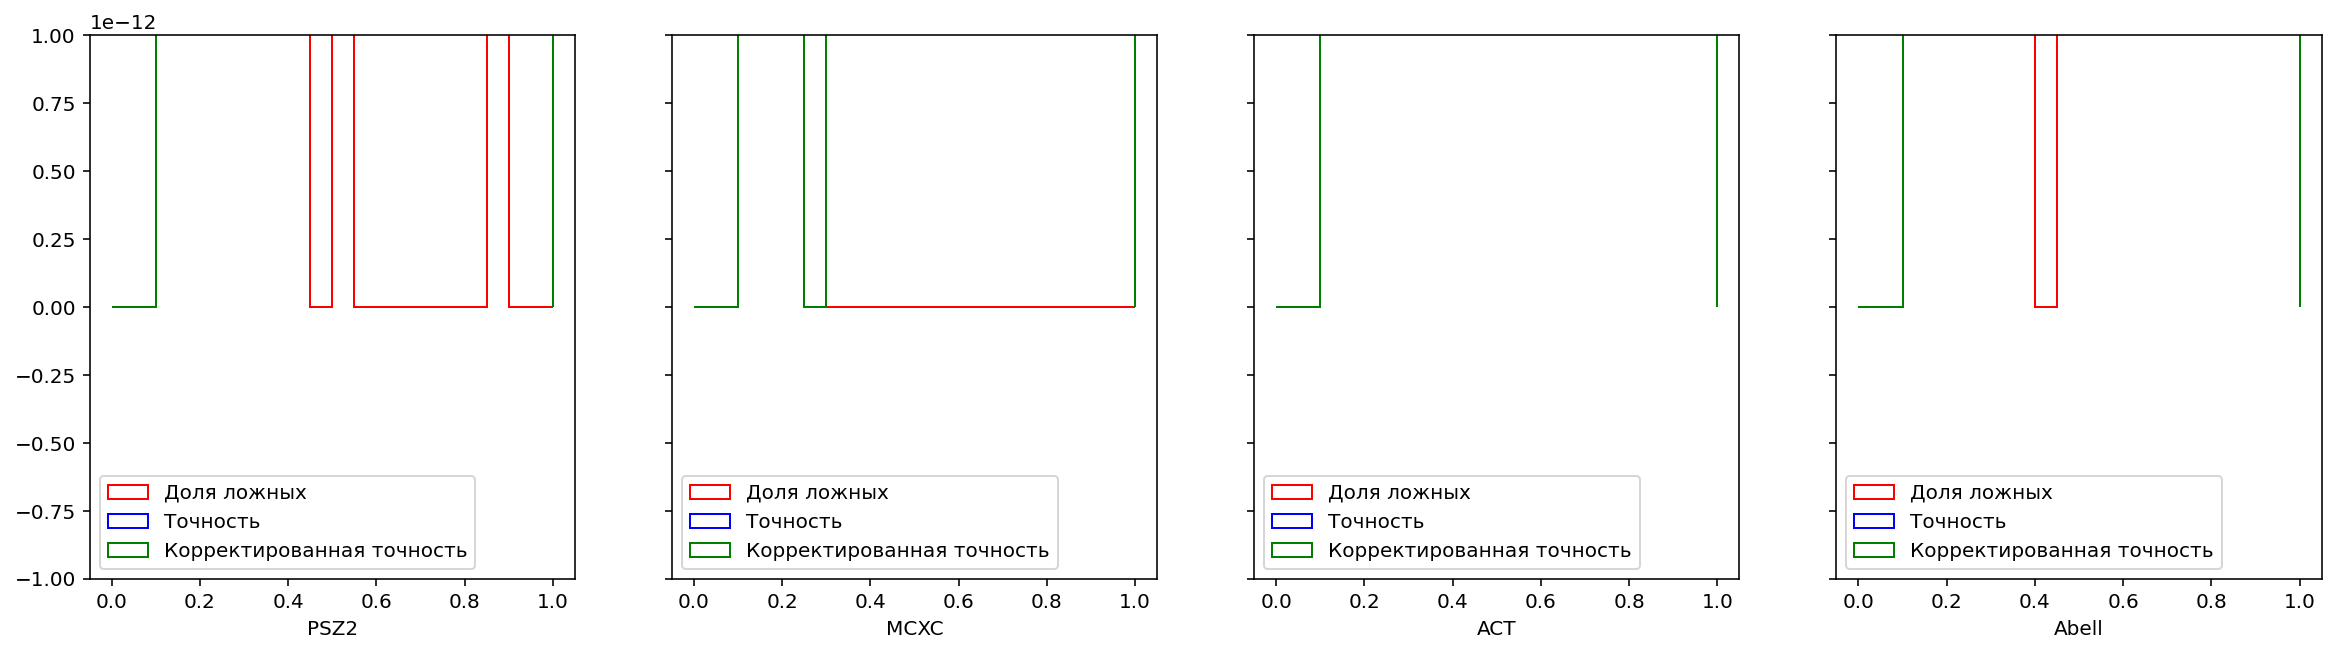

In [21]:
selected =  ['PSZ2', 'MCXC', 'ACT', 'Abell']
_, ax = plt.subplots(1, len(selected), figsize=(5 * len(selected), 5), sharey=True)
for i, cat_name in enumerate(selected):
    #ax[i].set_xlim([0.1, 1])
    ax[i].axhline(1, linestyle='--')
    ax[i].set_xlabel(cat_name)
    #ax[i].set_ylim([1, 10**4])
    make_histogram(ax[i], [counts_val[i].err_ratio(), counts_val[i].precision(), counts_val[i].corr_precision()], bins, 
                   label_list=['Доля ложных', 'Точность', 'Корректированная точность'], log=False)

In [15]:
bins = None
counts700 = []
for cat_name in tqdm(true_cats):
    bins, *c = found_all_error_calculated(pd.read_csv(det_cat), pd.read_csv(true_cats[cat_name]), small_rads=[0,700], n_bins=1) 
                                          #func_cat=lambda x:cut_cat(x, big_pix=val_pix))
    counts700.append(Counts_cat(cat_name, *c))

In [16]:
bins = None
counts1000 = []
for cat_name in tqdm(true_cats):
    bins, *c = found_all_error_calculated(pd.read_csv(det_cat), pd.read_csv(true_cats[cat_name]), small_rads=[0,1000], n_bins=1) 
                                          #func_cat=lambda x:cut_cat(x, big_pix=val_pix))
    counts1000.append(Counts_cat(cat_name, *c))

<ipython-input-5-75d17715fadd>:10: RuntimeWarning: invalid value encountered in true_divide
  return np.nan_to_num(self.error / self.found)
<ipython-input-5-75d17715fadd>:12: RuntimeWarning: invalid value encountered in true_divide
  return np.nan_to_num(self.found * self.found_coef / self.alls)
<ipython-input-5-75d17715fadd>:10: RuntimeWarning: invalid value encountered in true_divide
  return np.nan_to_num(self.error / self.found)
<ipython-input-5-75d17715fadd>:12: RuntimeWarning: invalid value encountered in true_divide
  return np.nan_to_num(self.found * self.found_coef / self.alls)
<ipython-input-5-75d17715fadd>:10: RuntimeWarning: invalid value encountered in true_divide
  return np.nan_to_num(self.error / self.found)
<ipython-input-5-75d17715fadd>:12: RuntimeWarning: invalid value encountered in true_divide
  return np.nan_to_num(self.found * self.found_coef / self.alls)
<ipython-input-5-75d17715fadd>:10: RuntimeWarning: invalid value encountered in true_divide
  return np.nan_t

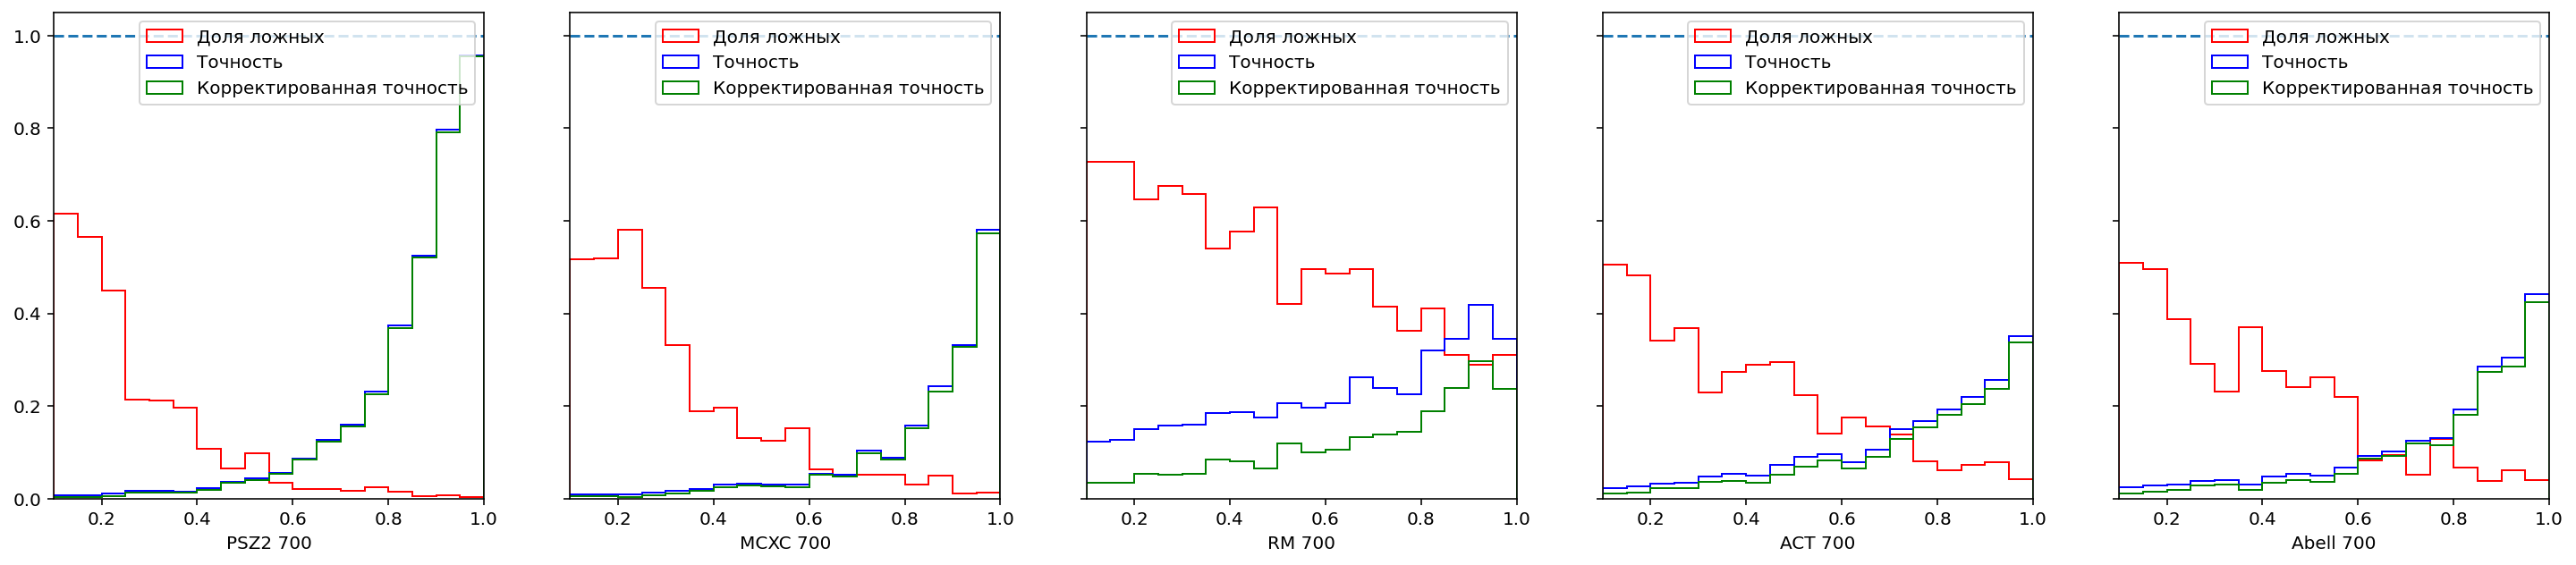

In [10]:
_, ax = plt.subplots(1, len(true_cats), figsize=(5 * len(true_cats), 5), sharey=True)
for i, cat_name in enumerate(true_cats):
    ax[i].set_xlim([0.1, 1])
    ax[i].axhline(1, linestyle='--')
    ax[i].set_xlabel(cat_name + ' 700')
    #ax.set_ylim([1, 10**4])
    make_histogram(ax[i], [counts700[i].err_ratio(), counts700[i].precision(), counts700[i].corr_precision()], bins, 
                   label_list=['Доля ложных', 'Точность', 'Корректированная точность'], log=False)

<ipython-input-5-75d17715fadd>:10: RuntimeWarning: invalid value encountered in true_divide
  return np.nan_to_num(self.error / self.found)
<ipython-input-5-75d17715fadd>:12: RuntimeWarning: invalid value encountered in true_divide
  return np.nan_to_num(self.found * self.found_coef / self.alls)
<ipython-input-5-75d17715fadd>:10: RuntimeWarning: invalid value encountered in true_divide
  return np.nan_to_num(self.error / self.found)
<ipython-input-5-75d17715fadd>:12: RuntimeWarning: invalid value encountered in true_divide
  return np.nan_to_num(self.found * self.found_coef / self.alls)
<ipython-input-5-75d17715fadd>:10: RuntimeWarning: invalid value encountered in true_divide
  return np.nan_to_num(self.error / self.found)
<ipython-input-5-75d17715fadd>:12: RuntimeWarning: invalid value encountered in true_divide
  return np.nan_to_num(self.found * self.found_coef / self.alls)
<ipython-input-5-75d17715fadd>:10: RuntimeWarning: invalid value encountered in true_divide
  return np.nan_t

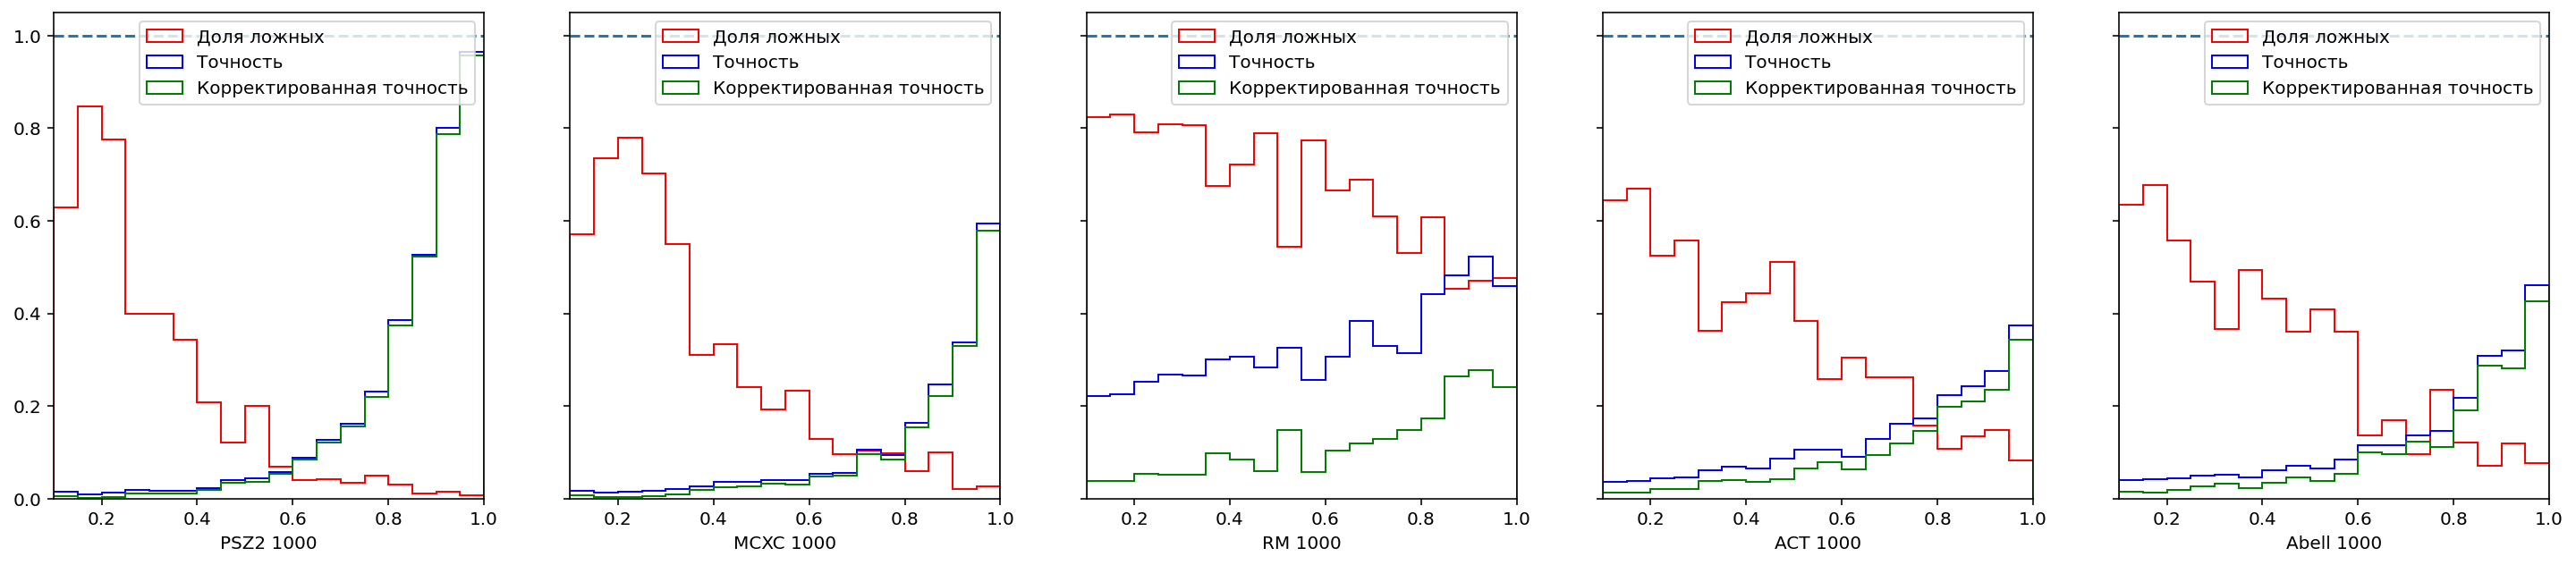

In [11]:
_, ax = plt.subplots(1, len(true_cats), figsize=(5 * len(true_cats), 5), sharey=True)
for i, cat_name in enumerate(true_cats):
    ax[i].set_xlim([0.1, 1])
    ax[i].axhline(1, linestyle='--')
    ax[i].set_xlabel(cat_name + ' 1000')
    #ax.set_ylim([1, 10**4])
    make_histogram(ax[i], [counts1000[i].err_ratio(), counts1000[i].precision(), counts1000[i].corr_precision()], bins, 
                   label_list=['Доля ложных', 'Точность', 'Корректированная точность'], log=False)

In [17]:
df = []
for rad, cur_counts in zip([400, 700, 1000], [counts, counts700, counts1000]):
    line = {}
    for i, cat_name in enumerate(true_cats):
        line[cat_name] = cur_counts[i].corr_precision().sum()
    df.append(line)
df = pd.DataFrame(df, index=[400, 700, 1000])
df

,PSZ2,MCXC,RM,ACT,Abell
400,0.065051,0.033829,0.057688,0.042953,0.039475
700,0.065065,0.036253,0.069102,0.045386,0.045462
1000,0.064585,0.036716,0.070786,0.045444,0.047302


In [19]:
import seaborn as sns
cm = sns.light_palette("green", as_cmap=True)

s = df.style.background_gradient(cmap=cm)
s

,PSZ2,MCXC,RM,ACT,Abell
400,0.065051,0.033829,0.057688,0.042953,0.039475
700,0.065065,0.036253,0.069102,0.045386,0.045462
1000,0.064585,0.036716,0.070786,0.045444,0.047302


In [14]:
bins, *c = found_all_error_calculated(pd.read_csv(det_cat), pd.read_csv(true_cats['PSZ2']), n_bins=20) 
                                      #func_cat=lambda x:cut_cat(x, big_pix=val_pix))
cc = Counts_cat('PSZ2', *c)

<ipython-input-6-75d17715fadd>:10: RuntimeWarning: invalid value encountered in true_divide
  return np.nan_to_num(self.error / self.found)
<ipython-input-6-75d17715fadd>:12: RuntimeWarning: invalid value encountered in true_divide
  return np.nan_to_num(self.found * self.found_coef / self.alls)


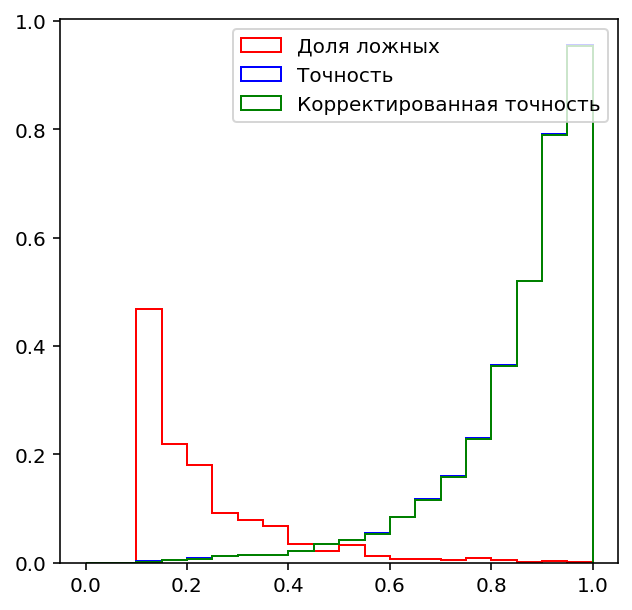

In [15]:
_, ax = plt.subplots(1, 1, figsize=(5, 5))
make_histogram(ax, [cc.err_ratio(), cc.precision(), cc.corr_precision()], bins, 
                   label_list=['Доля ложных', 'Точность', 'Корректированная точность'], log=False)

In [37]:
cats = ['planck_z', 'MCXC', 'ACT', 'Abell']
cats_dict = {}
for cat in cats: 
    bins, *c = found_all_error_calculated(pd.read_csv(det_cat), pd.read_csv(true_cats[cat]), n_bins=20) 
                                          #func_cat=lambda x:cut_cat(x, big_pix=val_pix))
    cc = Counts_cat(cat, *c)
    cats_dict[cat] = cc

In [38]:
df = pd.DataFrame({cat : cats_dict[cat].error * cats_dict[cat].err_coef for cat in cats}, index=bins[1:])
df.index.name='max_pred'
df.to_csv('/home/rt2122/L/check/errors.csv')

In [39]:
df

,planck_z,MCXC,ACT,Abell
max_pred,,,,
0.05,0.0,0.0,0.0,0.0
0.10,0.0,0.0,0.0,0.0
0.15,33.0,70.0,170.0,183.0
0.20,19.0,45.0,117.0,133.0
0.25,16.0,37.0,74.0,78.0
0.30,8.0,29.0,62.0,55.0
0.35,5.0,22.0,44.0,37.0
0.40,6.0,12.0,44.0,34.0
0.45,4.0,15.0,36.0,33.0
